In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-7 # erodibility
beta = 0.0005 # abradability
r = 10. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction plucked that becomes coarse
theta = 0.5 # fraction hillslope that enters as coarse
# treat as same!!! Point is what fraction becomes coarse
# so just be sure to change these together

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma, theta,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 10
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * gamma
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * theta)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p[:-1] - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 5000000

test_run = [x, dx, x_node, 
            K, beta, gamma, theta,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

50000000.0


In [7]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

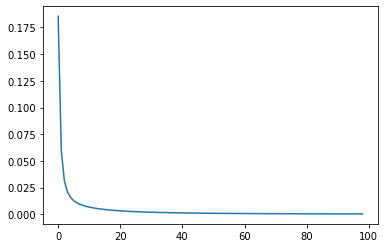

In [8]:
plt.plot(S)

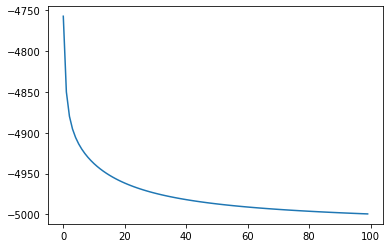

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.00028980498565397283

In [11]:
eta

array([-4757.0579642 , -4849.83167656, -4879.73071795, -4895.32502241,
       -4905.69616031, -4913.5344329 , -4919.89143653, -4925.26765505,
       -4929.93748597, -4934.0678619 , -4937.76863543, -4941.11661563,
       -4944.16812511, -4946.96605571, -4949.54407735, -4951.92927764,
       -4954.14388953, -4956.20646439, -4958.13269451, -4959.93600624,
       -4961.62799846, -4963.21877389, -4964.71719433, -4966.1310807 ,
       -4967.46737222, -4968.73225491, -4969.93126641, -4971.06938257,
       -4972.15108951, -4973.18044433, -4974.16112636, -4975.09648102,
       -4975.98955732, -4976.84314032, -4977.65977923, -4978.44181192,
       -4979.19138635, -4979.91047938, -4980.60091341, -4981.26437103,
       -4981.90240803, -4982.51646502, -4983.10787775, -4983.67788633,
       -4984.22764352, -4984.7582222 , -4985.27062199, -4985.76577539,
       -4986.24455311, -4986.70776912, -4987.15618503, -4987.59051424,
       -4988.01142554, -4988.41954654, -4988.81546674, -4989.19974029,
      

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([2.42342036e+02, 1.49568324e+02, 1.19669283e+02, 1.04074978e+02,
       9.37038402e+01, 8.58655677e+01, 7.95085640e+01, 7.41323455e+01,
       6.94625146e+01, 6.53321387e+01, 6.16313651e+01, 5.82833849e+01,
       5.52318754e+01, 5.24339448e+01, 4.98559232e+01, 4.74707229e+01,
       4.52561110e+01, 4.31935362e+01, 4.12673060e+01, 3.94639943e+01,
       3.77720021e+01, 3.61812267e+01, 3.46828062e+01, 3.32689199e+01,
       3.19326283e+01, 3.06677457e+01, 2.94687341e+01, 2.83306180e+01,
       2.72489110e+01, 2.62195562e+01, 2.52388742e+01, 2.43035195e+01,
       2.34104432e+01, 2.25568602e+01, 2.17402213e+01, 2.09581886e+01,
       2.02086142e+01, 1.94895212e+01, 1.87990871e+01, 1.81356295e+01,
       1.74975925e+01, 1.68835355e+01, 1.62921228e+01, 1.57221142e+01,
       1.51723570e+01, 1.46417784e+01, 1.41293786e+01, 1.36342252e+01,
       1.31554474e+01, 1.26922314e+01, 1.22438155e+01, 1.18094863e+01,
       1.13885750e+01, 1.09804540e+01, 1.05845338e+01, 1.02002603e+01,
      

In [14]:
# save csv files

np.savetxt('elevation csv files/eta_exp_8.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_8.csv', alpha, delimiter = ',')